# Test grid sampling

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
import scipy.interpolate
from tqdm import tqdm

sys.path.append("..")
import ment.samp

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

Create a particle distribution.

In [3]:
# Settings
dim = 6
size = int(4.00e+05)
n_modes = 5
seed = 1241

# Create gaussian particle distribution.
rng = np.random.default_rng(seed)
mean = np.zeros(dim)
cov = np.identity(dim)
for i in range(dim):
    for j in range(i):
        cov[i, j] = cov[j, i] = rng.uniform(-0.2, 0.2)
x = rng.multivariate_normal(mean, cov, size=size)

# Add some Gaussian blobs.
for _ in range(n_modes):
    scale = rng.uniform(0.5, 1.5, size=dim)
    loc = rng.uniform(-3.0, 3.0, size=dim)
    x = np.vstack([x, rng.normal(loc=loc, scale=scale, size=(size // n_modes, dim))])
x = x - np.mean(x, axis=0)

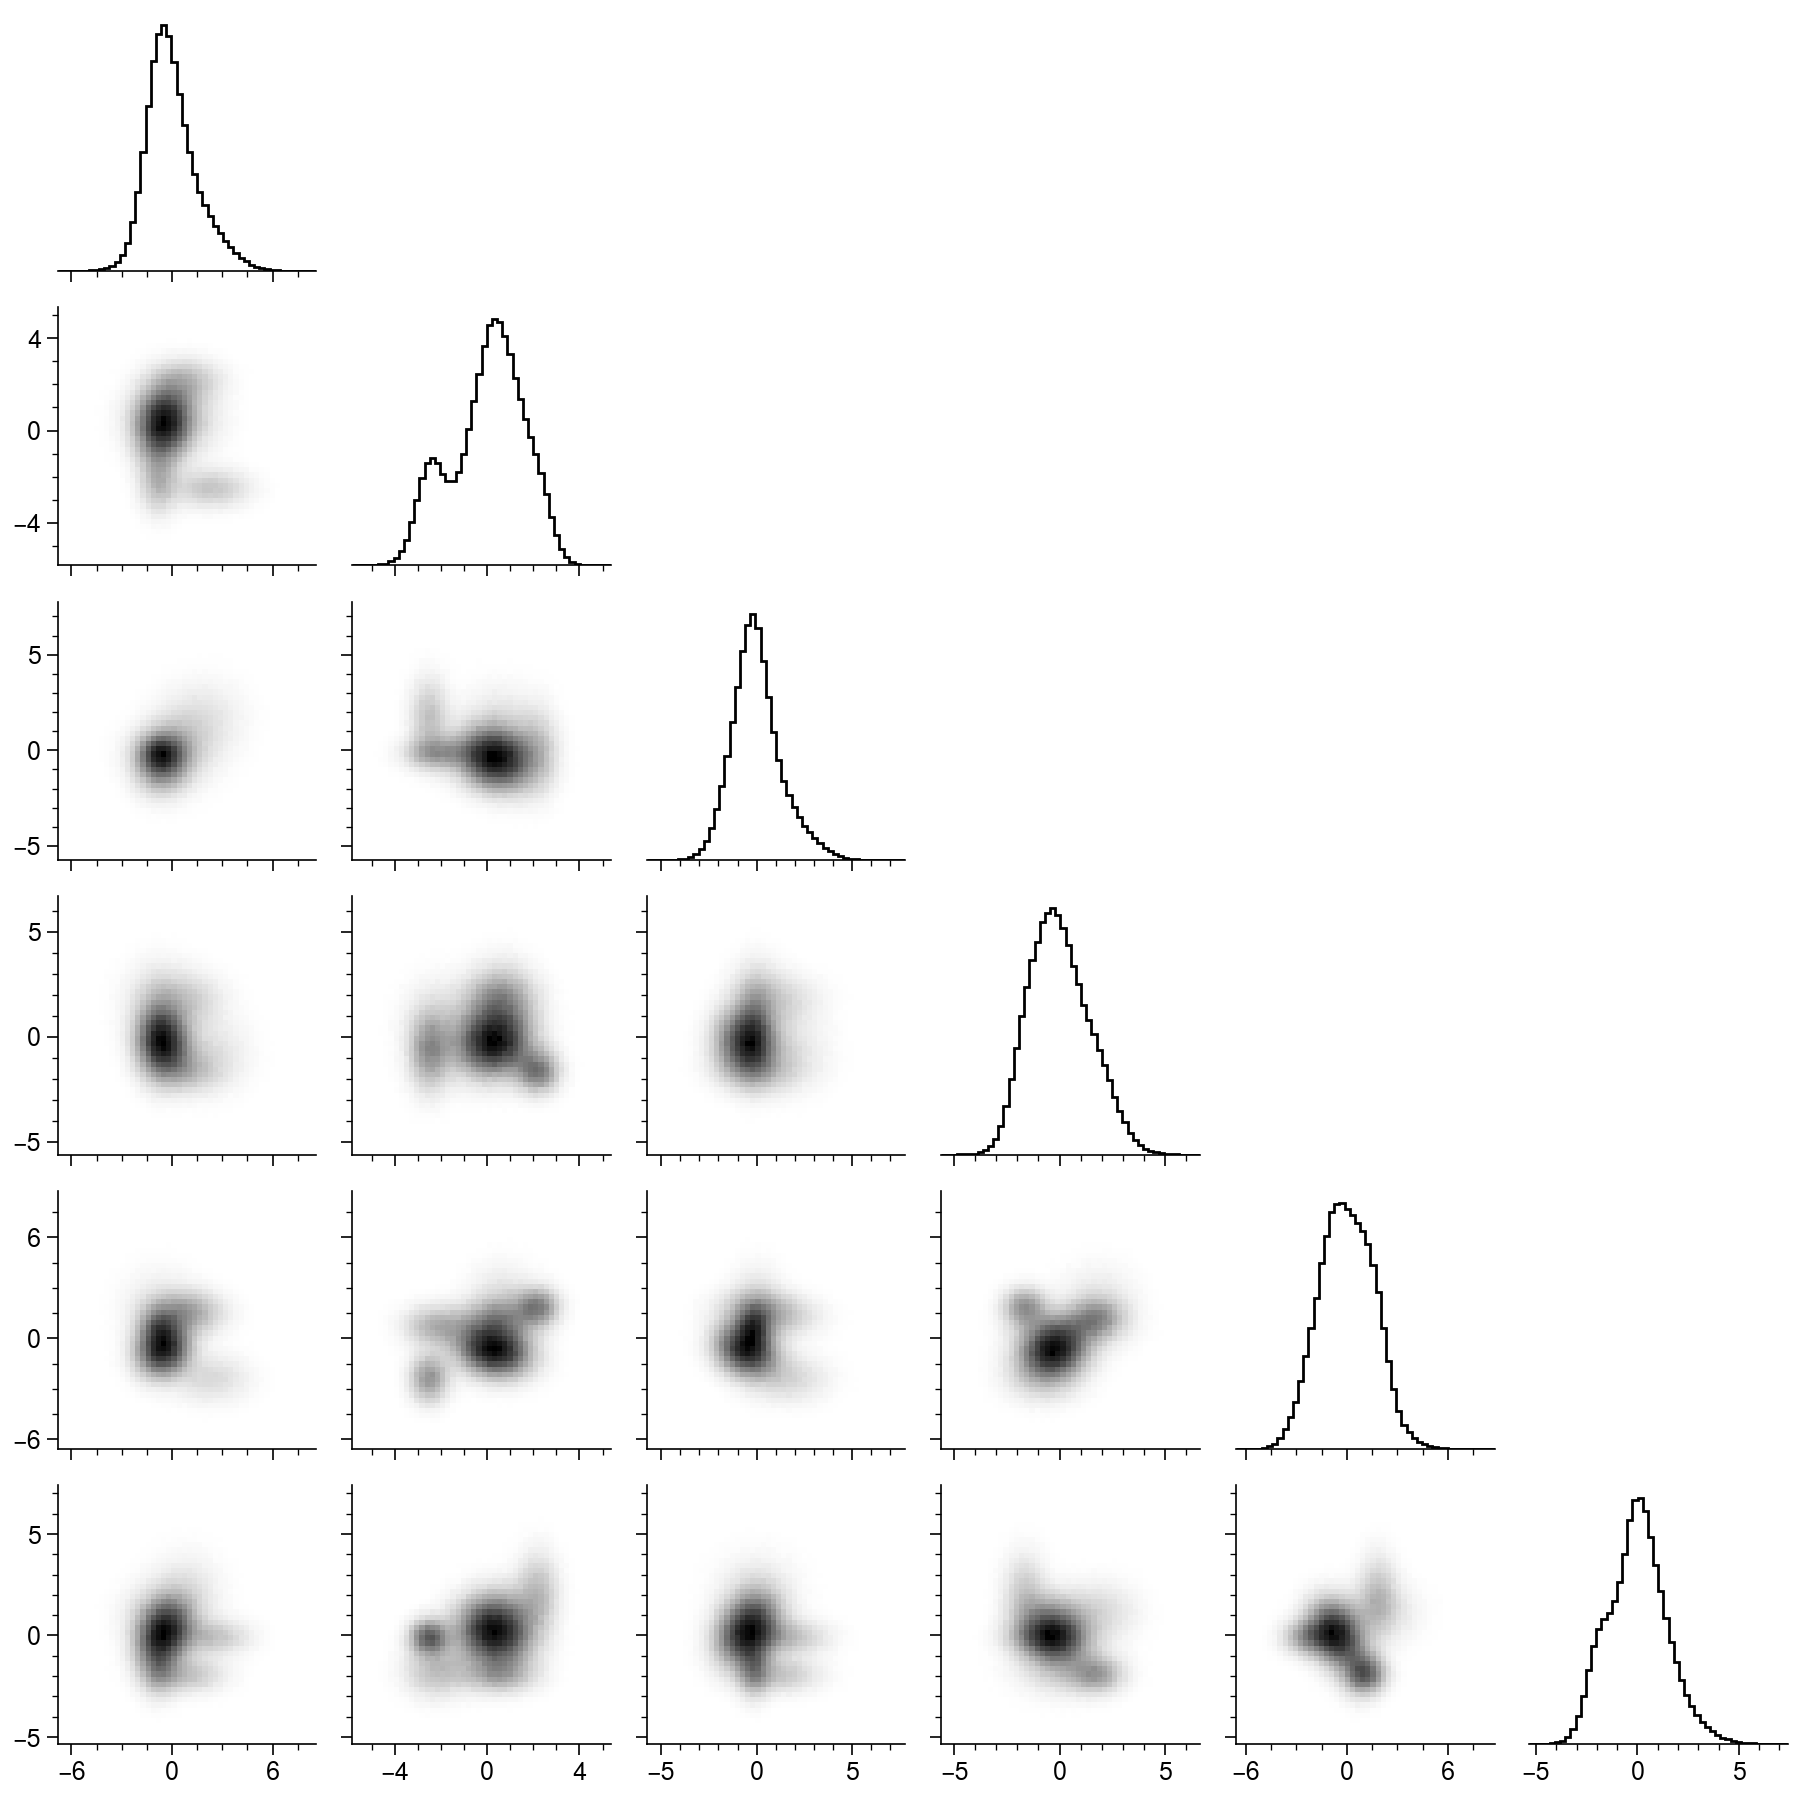

In [4]:
limits = ps.points.limits(x)
grid = psv.CornerGrid(dim, corner=True)
grid.plot_points(
    x, 
    bins=50, 
    limits=limits, 
    cmap="mono",
)
plt.show()

Compute ground-truth histogram.

In [5]:
n_bins = 25
hist, edges = np.histogramdd(x, bins=n_bins, range=limits, density=True)
coords = [0.5 * (e[:-1] + e[1:]) for e in edges]
print("hist.shape =", hist.shape)

hist.shape = (25, 25, 25, 25, 25, 25)


Interpolate to obtain a smooth density function.

In [6]:
prob_func = scipy.interpolate.RegularGridInterpolator(
    coords, hist, method="linear", bounds_error=False, fill_value=0.0,
)

## Grid Sampling (GS)

Sample from the distribution.

In [7]:
samp_grid_res = 15  # limit ~ 15
grid_shape = [samp_grid_res] * dim
grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    noise=0.0,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

time: 12.895648717880249


Plot a samples over histogram projections.

In [8]:
def plot_corner_00(x, x_samp):
    limits = ps.points.limits(x)
    grid = psv.CornerGrid(dim, corner=True)
    grid.set_limits(limits)
    grid.plot_image(hist, coords=coords, cmap="mono")
    grid.plot_points(
        x_samp[:1000, :], 
        kind="scatter", 
        color="red", 
        s=0.5,
        diag_kws=dict(color="red")
    )
    return grid
    
def plot_corner_01(x, x_samp):
    limits = ps.points.limits(x)
    grid = psv.CornerGrid(dim, corner=False)
    grid.set_limits(limits)
    grid.plot_image(hist, coords=coords, lower=False, cmap="mono")
    grid.plot_points(x_samp, upper=False, bins=n_bins, limits=limits, cmap="mono")
    return grid

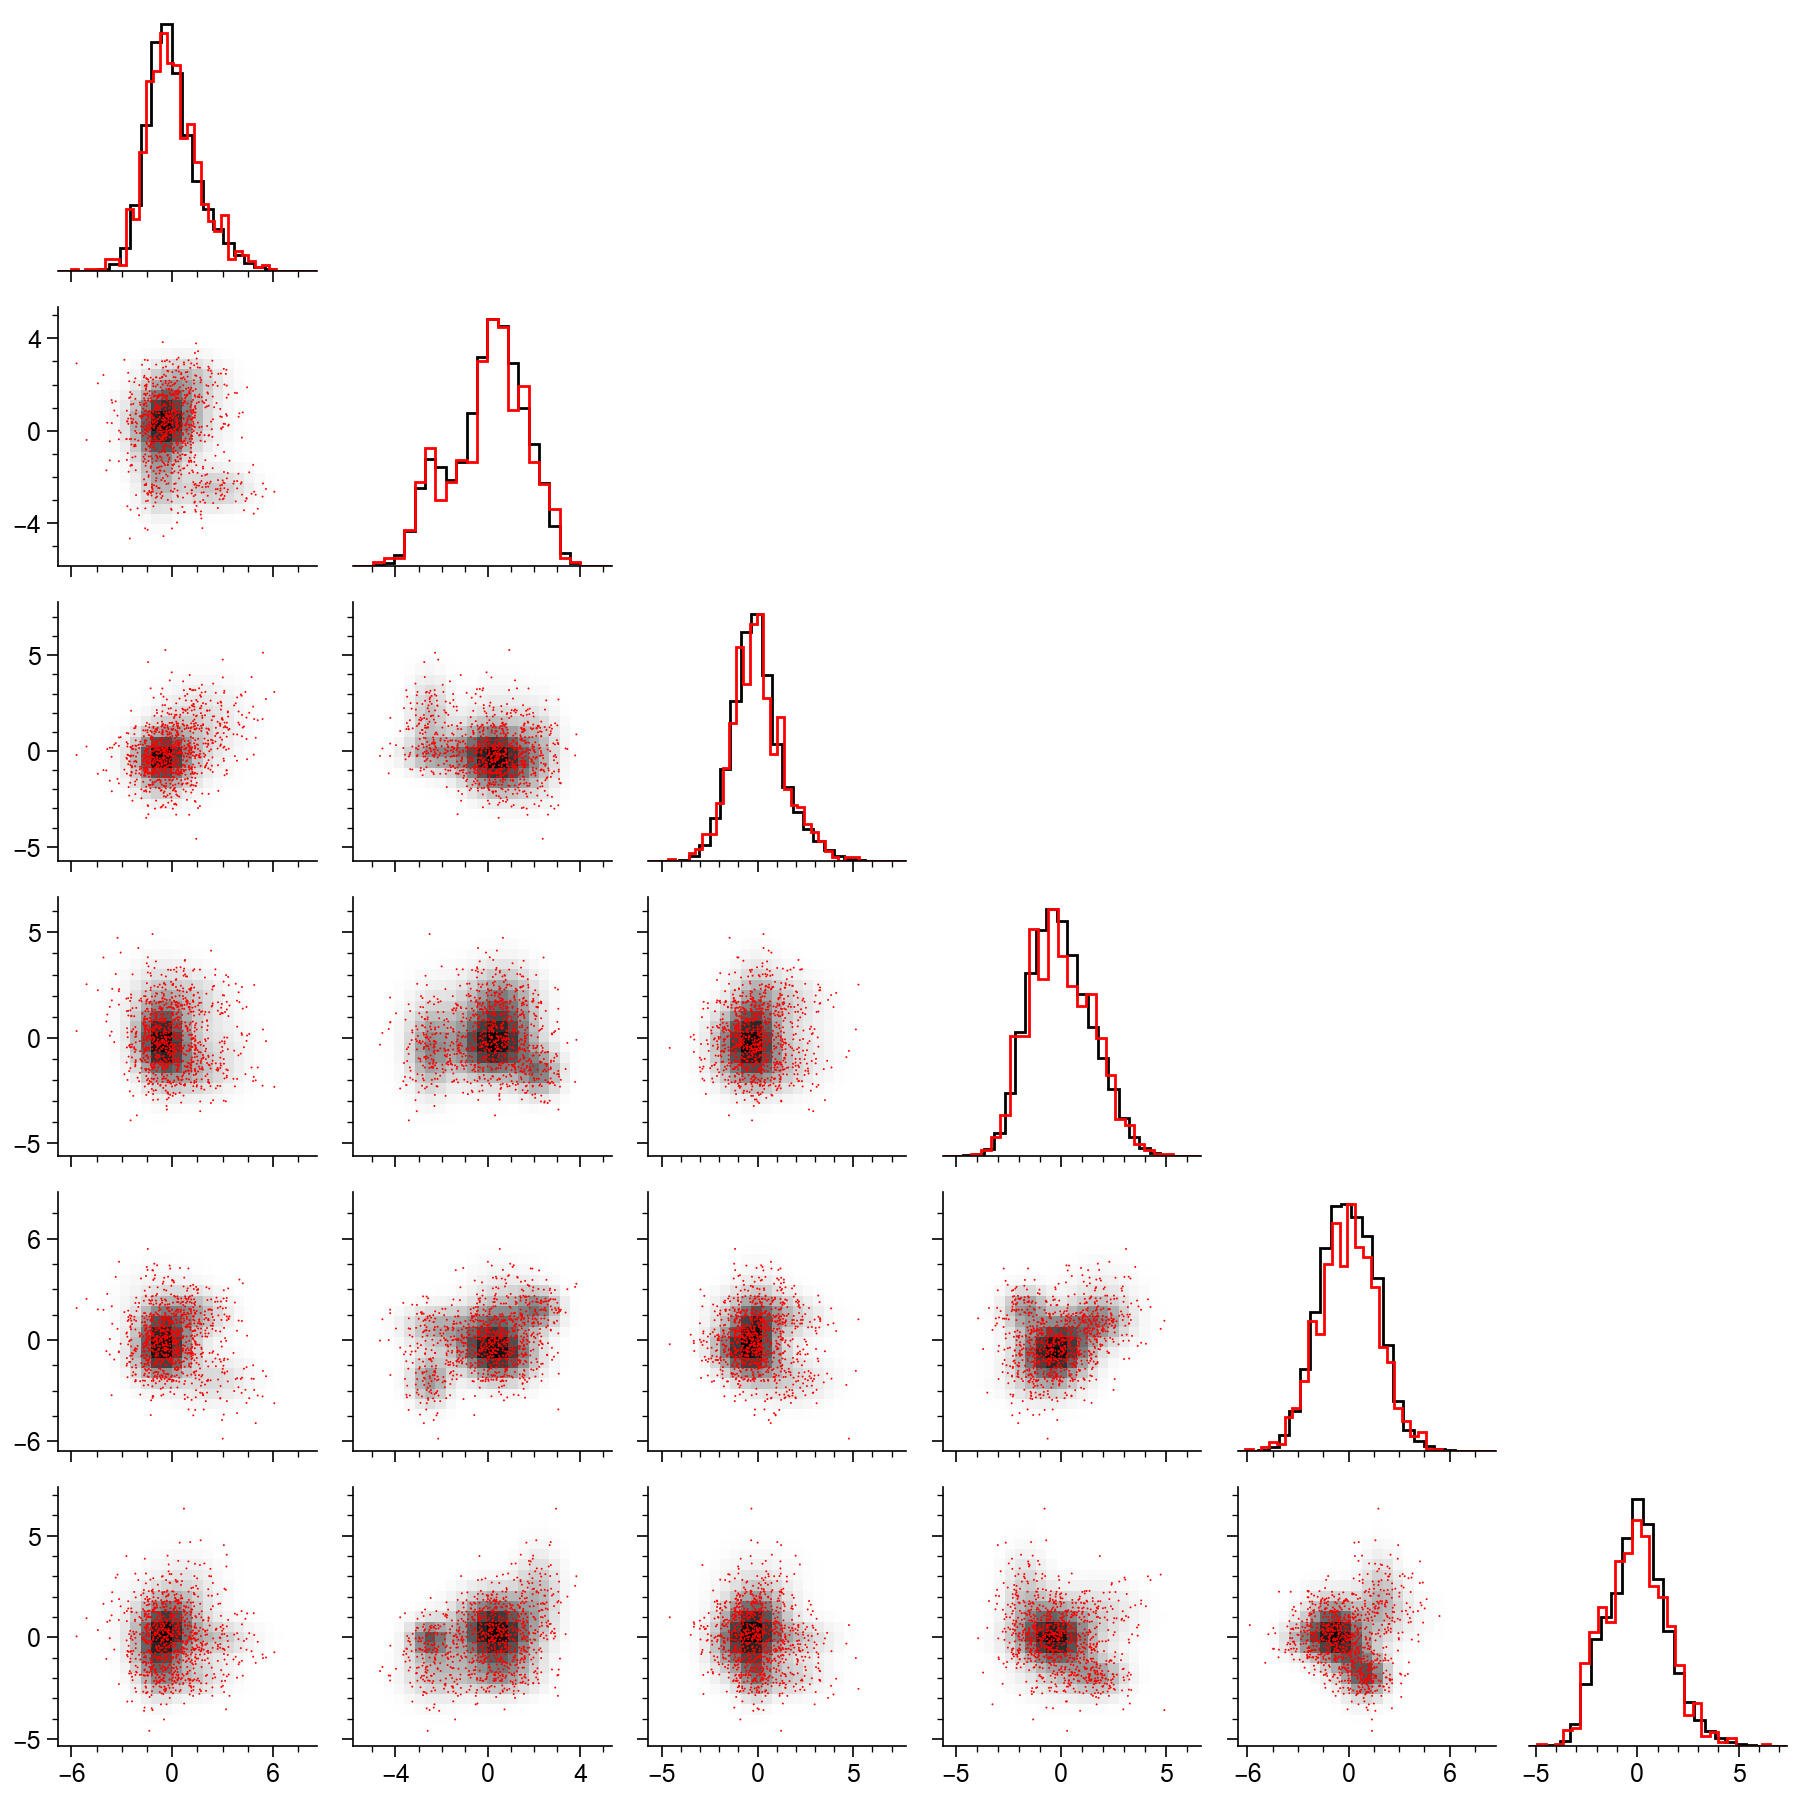

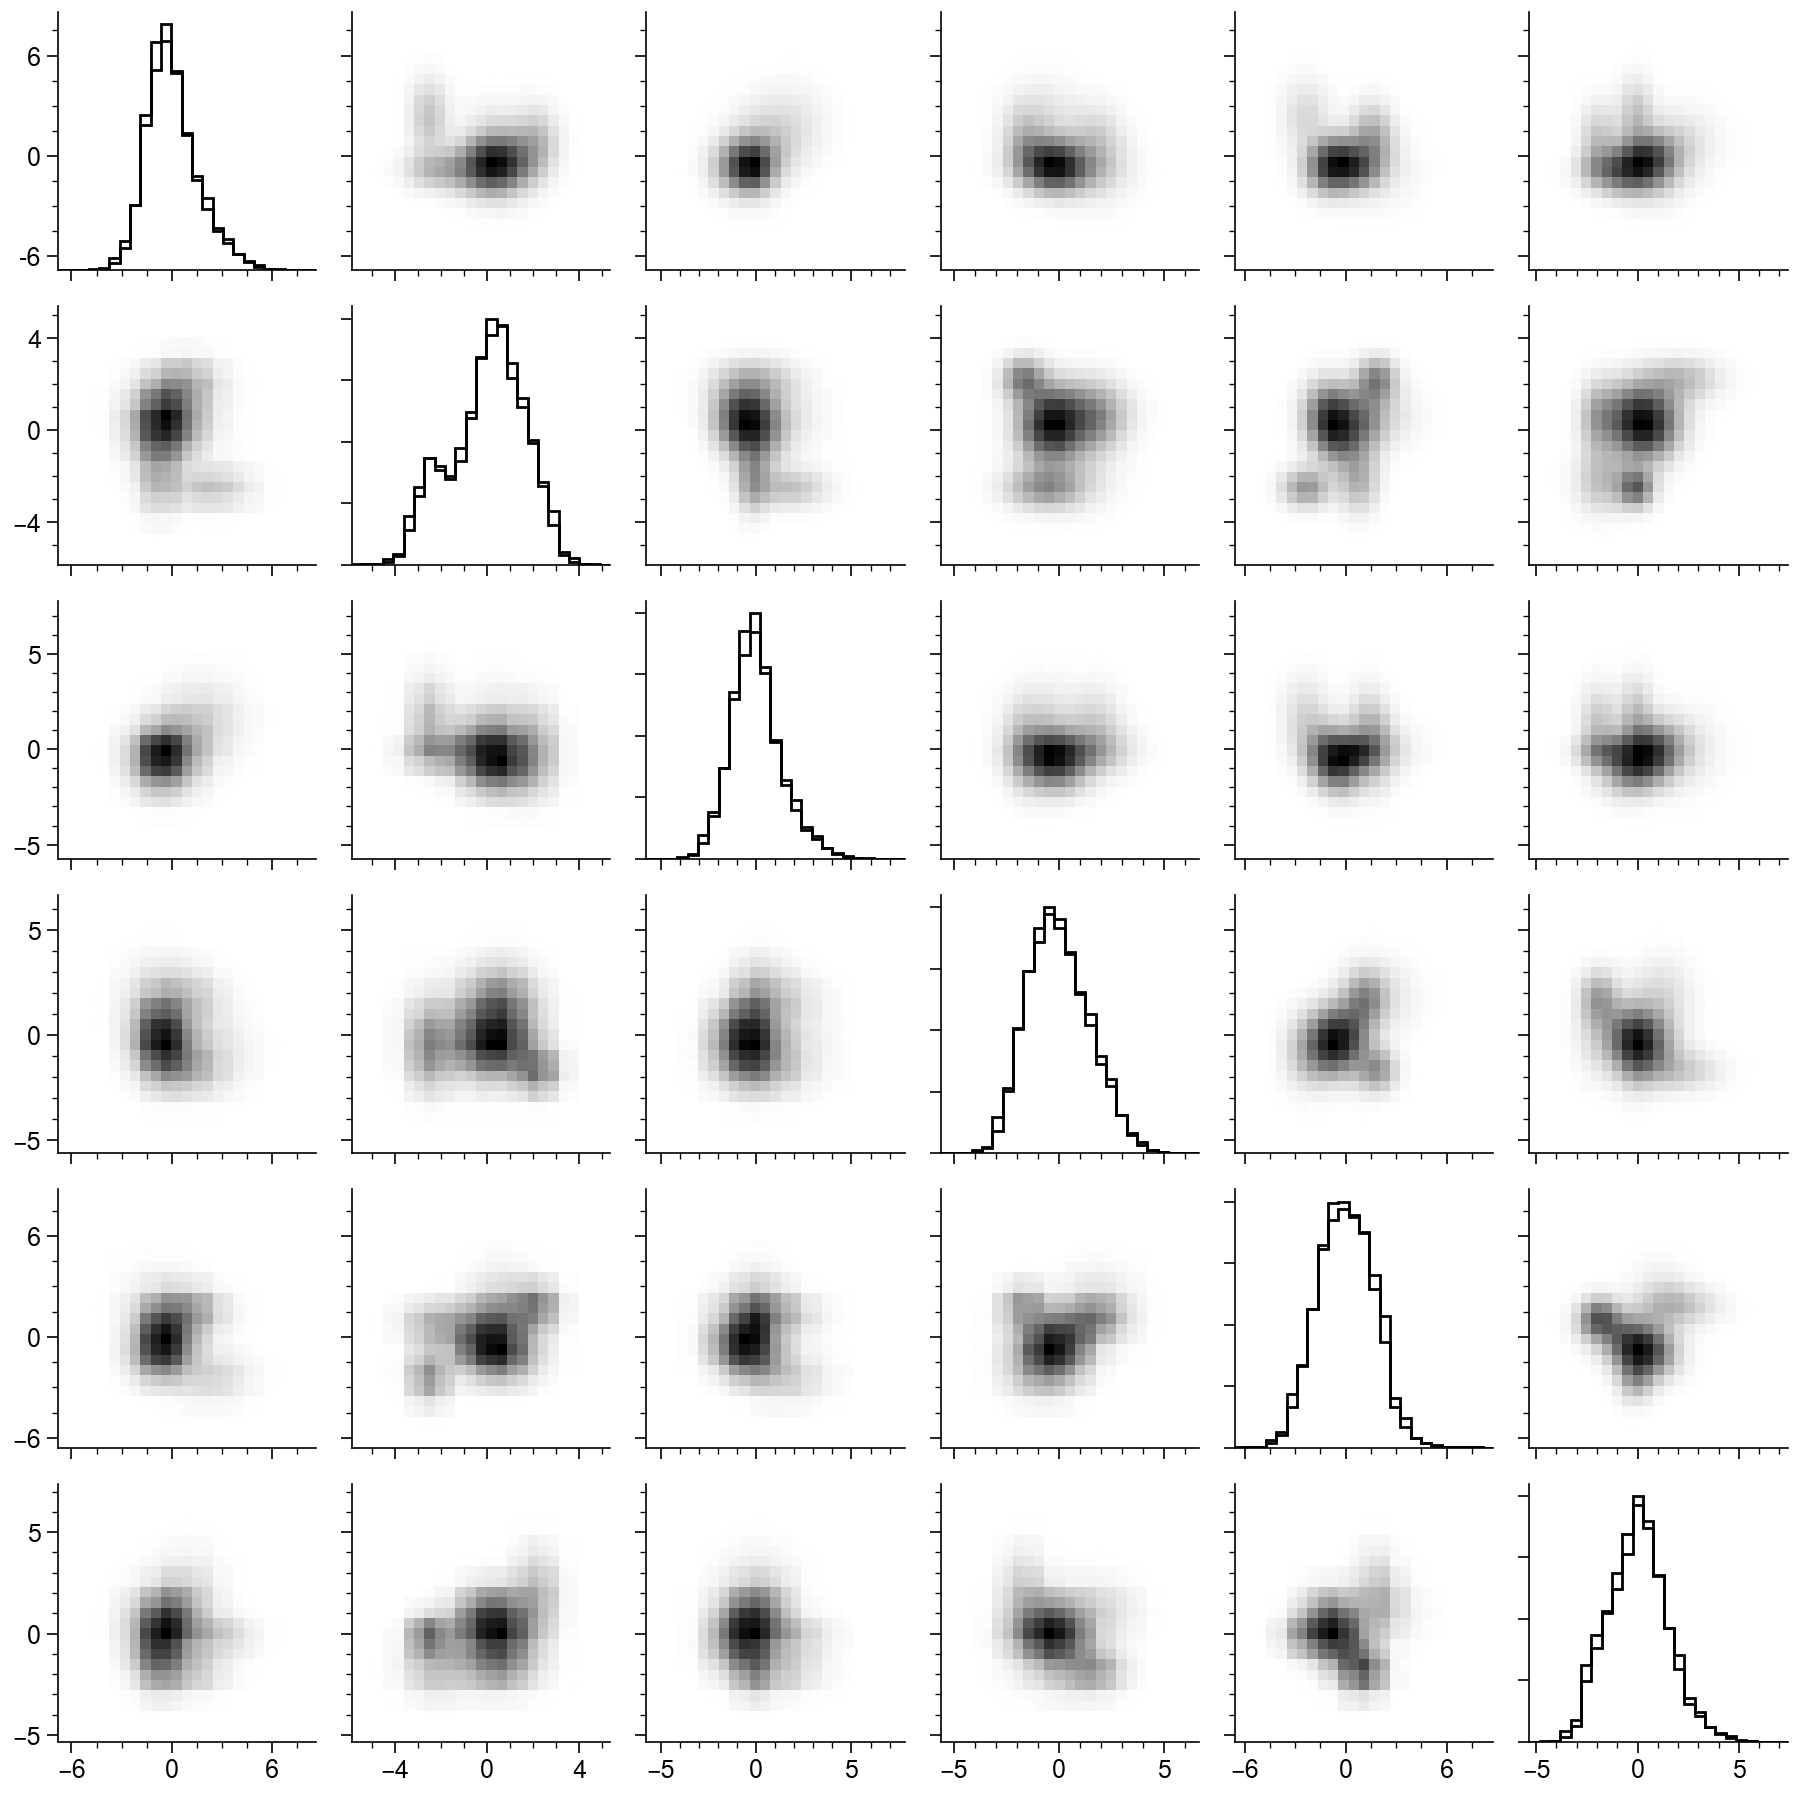

In [9]:
plot_corner_00(x, x_samp)
plot_corner_01(x, x_samp)

## Slice Grid Sampling (GS)

In [10]:
samp_res = 20
int_res  = 10

ndim = dim
ndim_proj = 2
ndim_samp = ndim_int = ndim - ndim_proj

grid_shape = [samp_res] * ndim
grid_limits = limits
int_size = int(int_res ** ndim_int)

sampler = ment.samp.SliceGridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    proj_dim=ndim_proj,
    int_size=int_size,
    int_method="grid",
    int_batches=1,
    noise=0.0,
    verbose=True,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

Projecting


100%|██████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 129.71it/s]


Sampling


400it [00:30, 12.99it/s]


time: 34.20719385147095


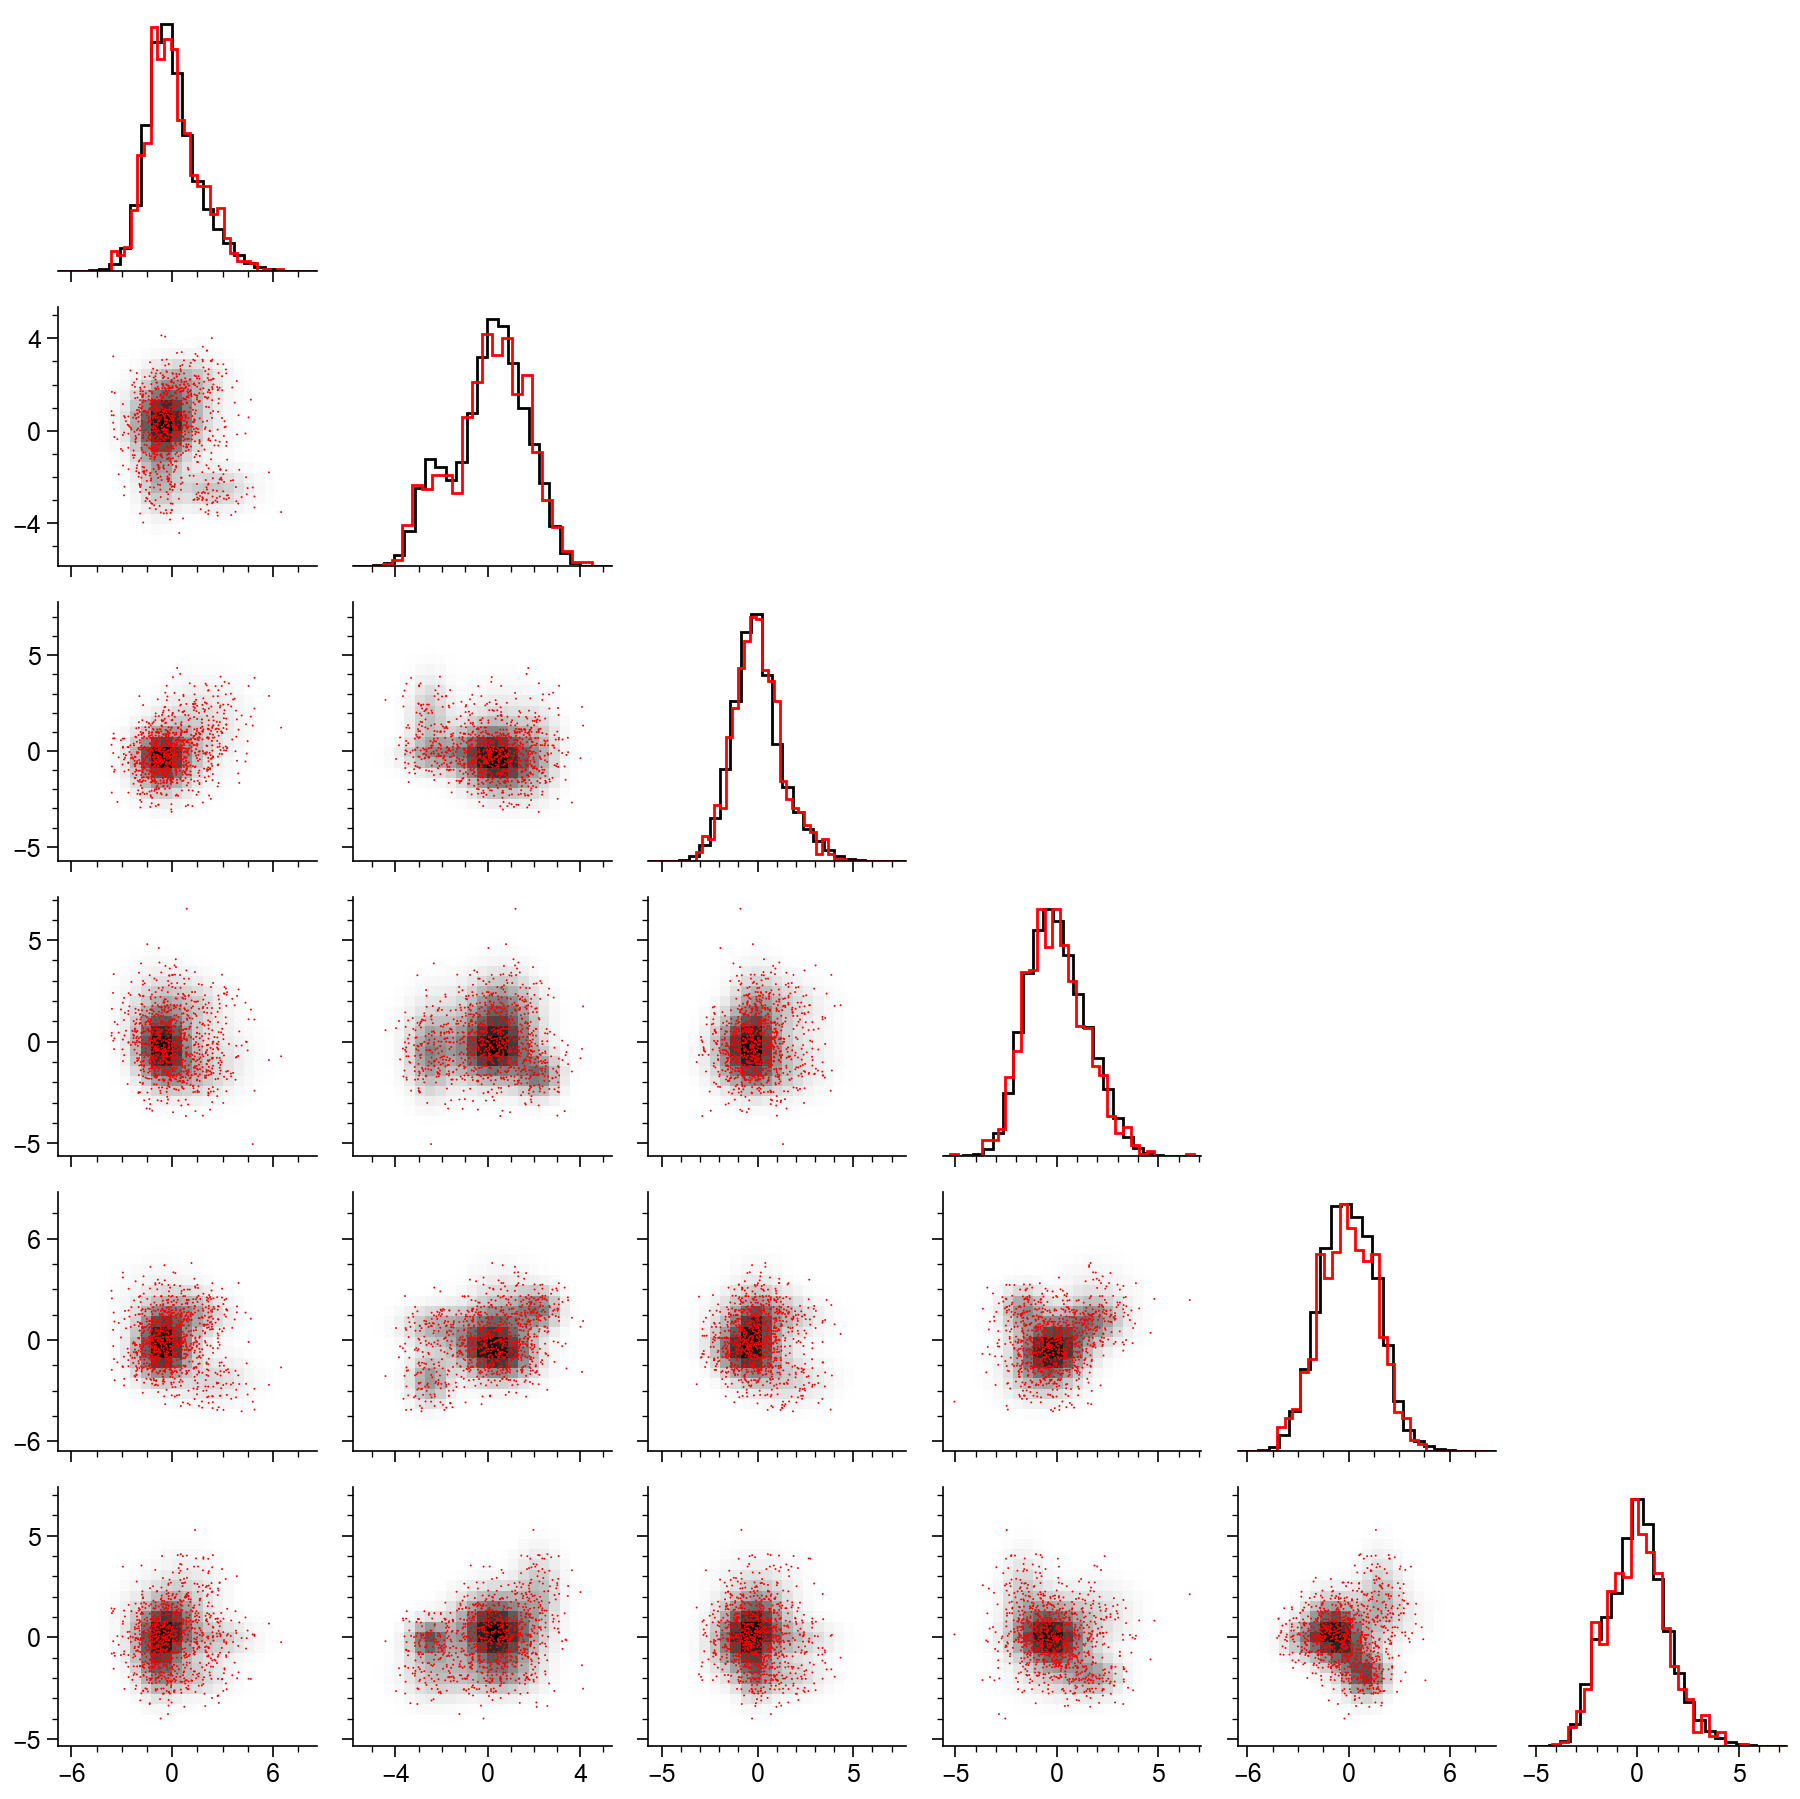

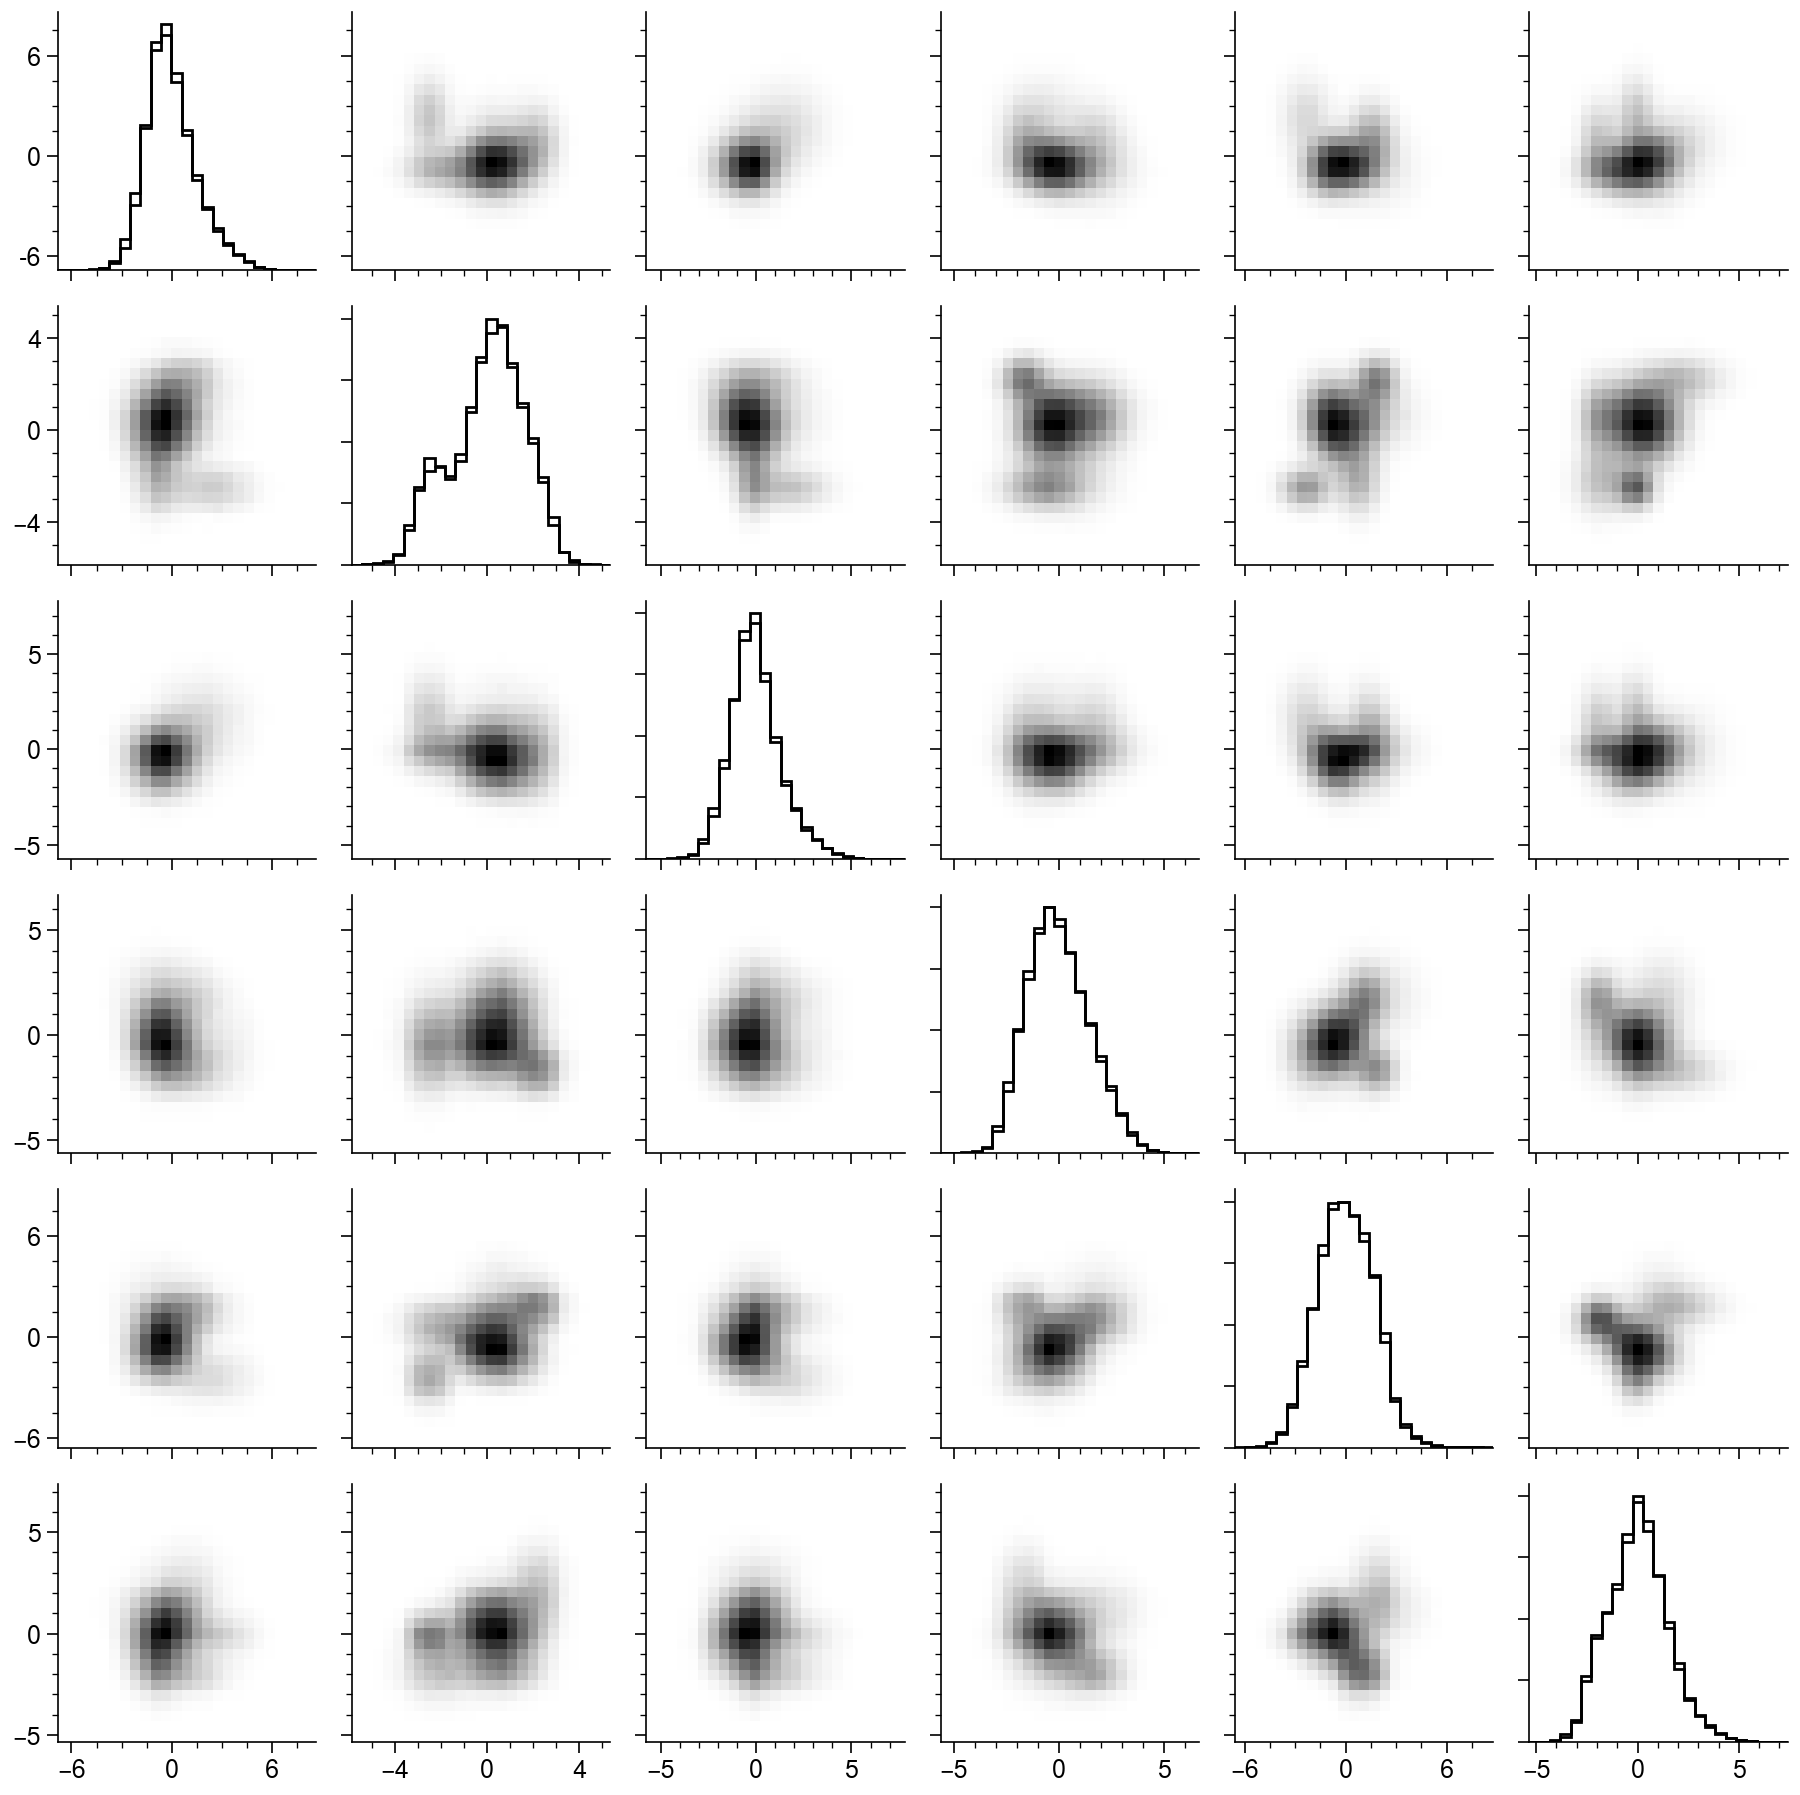

In [11]:
plot_corner_00(x, x_samp)
plot_corner_01(x, x_samp)

## Metropolis Hastings

In [12]:
sampler = ment.samp.MetropolisHastingsSampler(ndim=ndim, scale=1.0, burnin=100_000, shuffle=True)
x_samp = sampler(prob_func, size=200_000)

100%|███████████████████████████████████████████████████████████████████████████| 300000/300000 [02:36<00:00, 1917.99it/s]


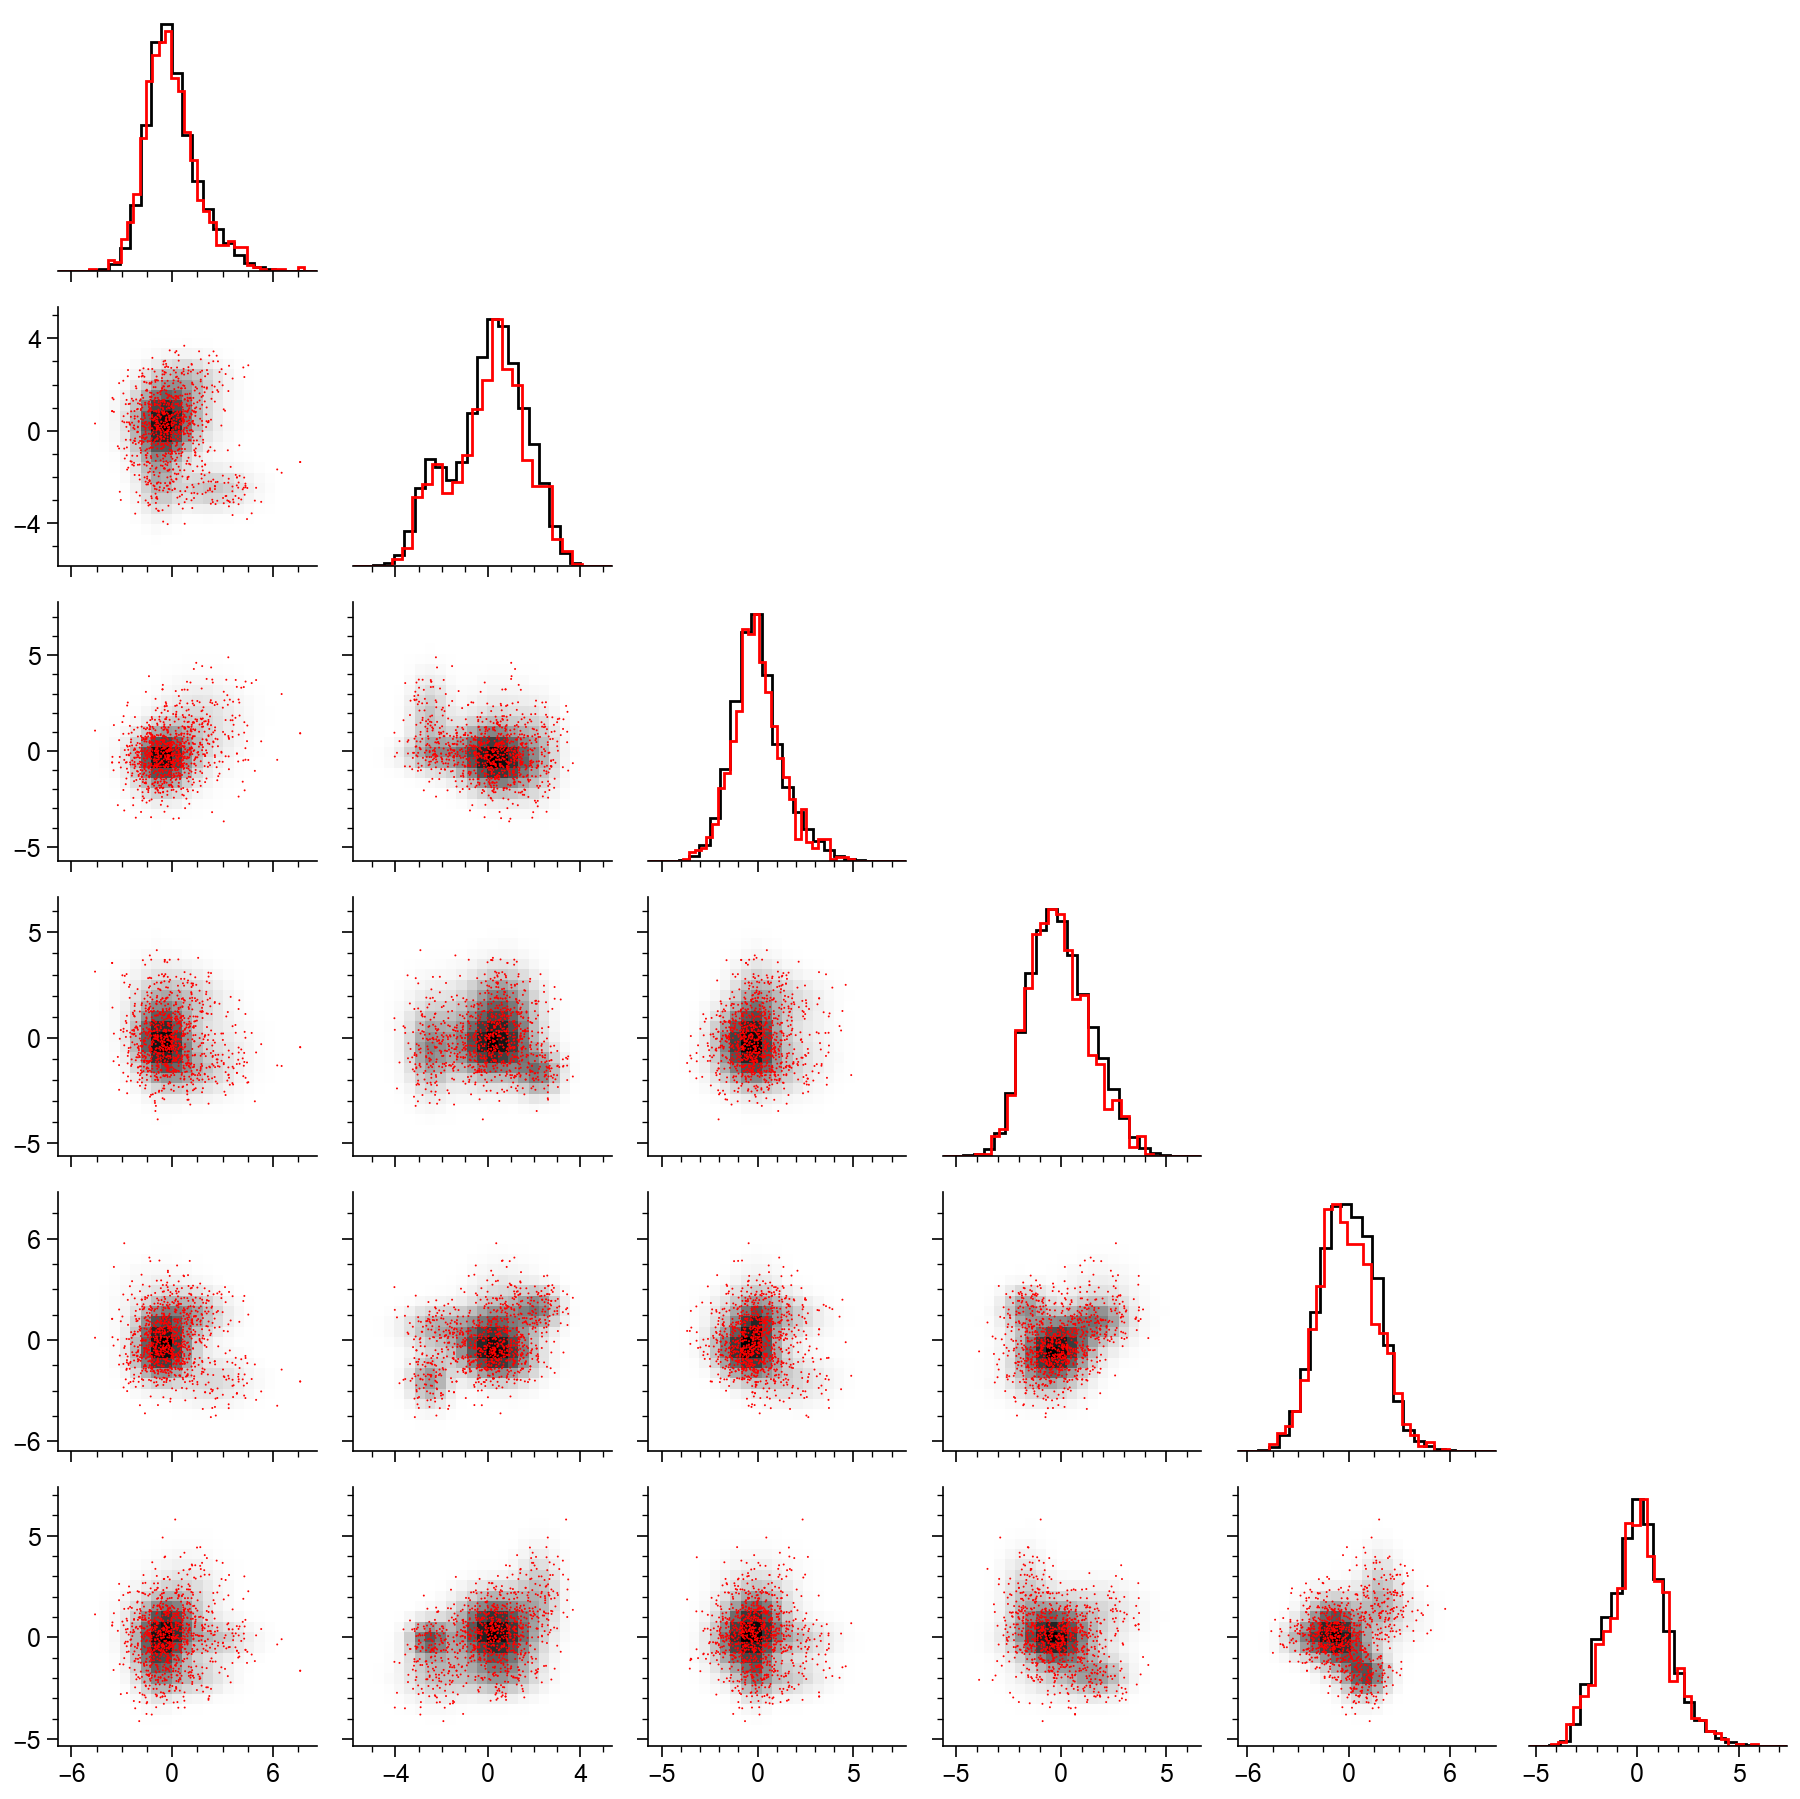

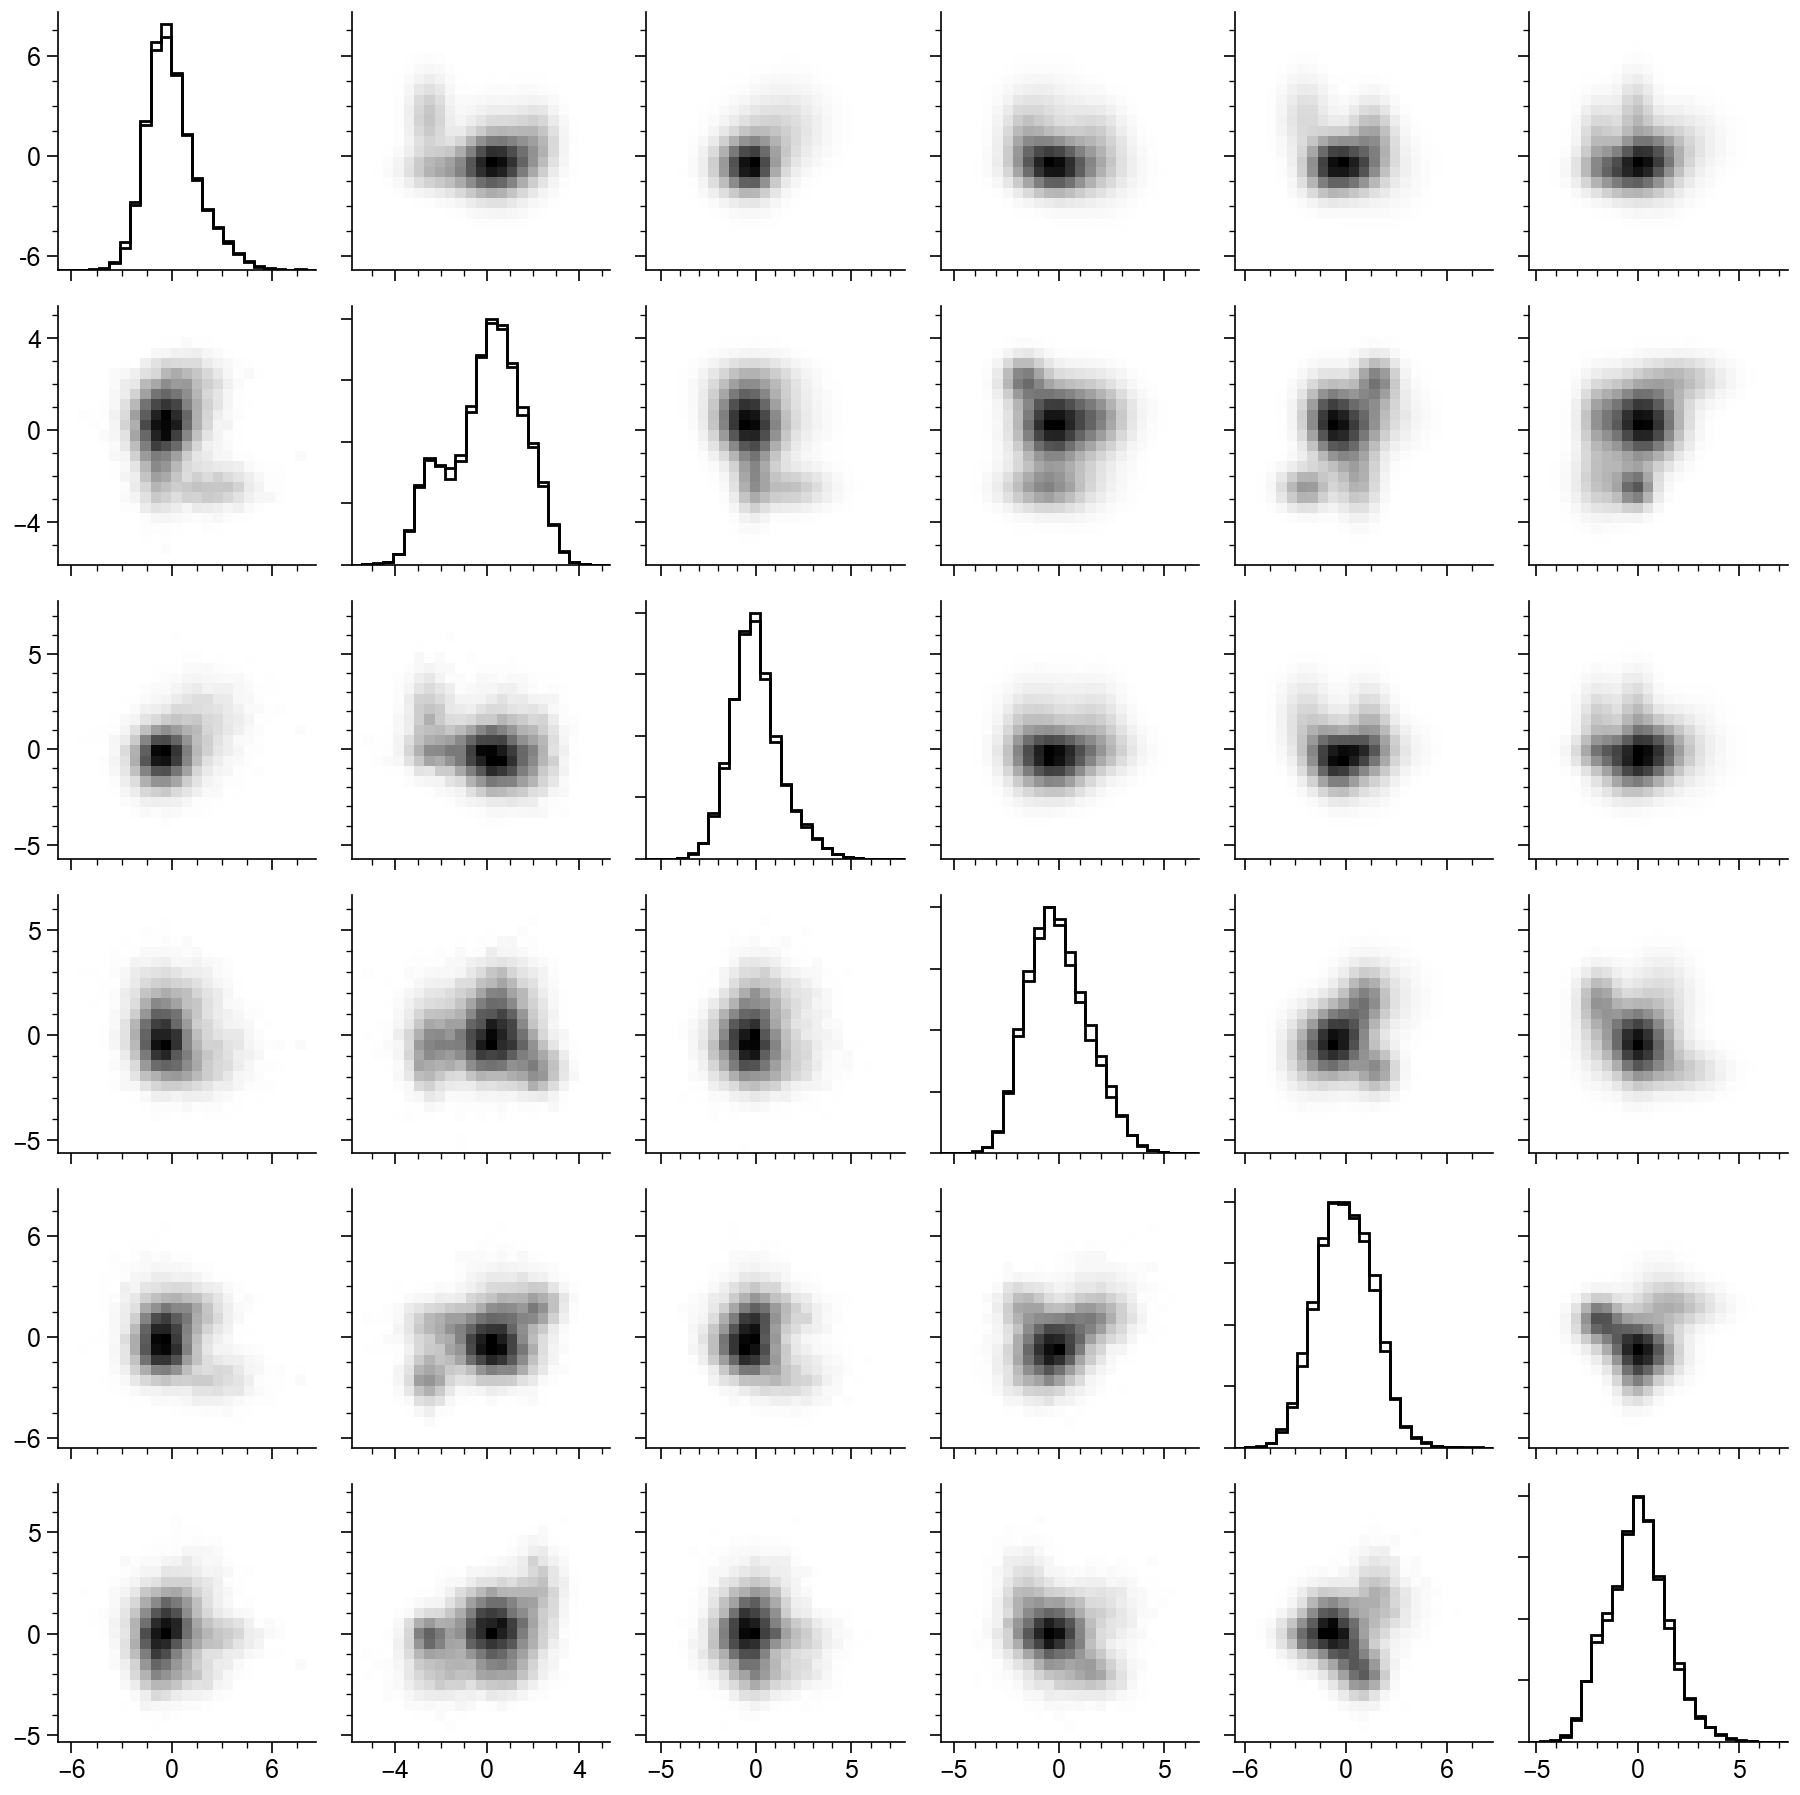

In [13]:
plot_corner_00(x, x_samp)
plot_corner_01(x, x_samp)